# Analyse K562 P2 MinION & R9 run from  20204/11/27, 20204/09/27 

In [3]:

from dimelo import parse_bam, plot_enrichment_profile, plot_reads
import matplotlib.pyplot as plt
from pathlib import Path
     

modkit found with expected version 0.2.4


In [4]:
! ls "/home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562"

bams_pass_merged.bam	 to_hg19  to_k562_spr30588077  to_t2t_v1_1
post_seq_basecall_align  to_hg38  to_t2t_v1_0	       trim_bam_pass_merged.bam


In [5]:
! ls "/home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1"

aligned_T2Tv1_1_trim_bam_pass_merged.bam
more_mismatches
sort_aligned_T2Tv1_1_trim_bam_pass_merged.bam
sort_aligned_T2Tv1_1_trim_bam_pass_merged.bam.bai
sort_aligned_T2Tv1_1_trim_bam_pass_merged.updated.bam
sort_aligned_T2Tv1_1_trim_bam_pass_merged.updated.bam.bai
summary_aligned_T2Tv1_1_trim_bam_pass_merged.tsv


### System Information
Run this cell to list system information about your machine

In [6]:
import platform
print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

#  Pyton version
import sys
print(sys.version)
     

System: Linux
Release: 6.8.0-49-generic
Version: #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
Processor: x86_64
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [7]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam
import pandas as pd
from dimelo import plot_enrichment_profile, load_processed, parse_bam, utils

import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

import numpy as np


#### Download & Use the T2T v.1.1 -> for my Cas9 runs

! mkdir ./test/output/
!wget https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz -O ./test/output/chm13.draft_v1.1.fasta.gz
!gunzip ./test/output/chm13.draft_v1.1.fasta.gz
     
--2024-04-17 15:37:02--  https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.238.208, 52.218.235.48, 52.92.131.176, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.238.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892637258 (851M) [binary/octet-stream]
Saving to: ‘./test/output/chm13.draft_v1.1.fasta.gz’

./test/output/chm13 100%[===================>] 851.29M  39.5MB/s    in 22s     

2024-04-17 15:37:24 (39.5 MB/s) - ‘./test/output/chm13.draft_v1.1.fasta.gz’ saved [892637258/892637258]


!pwd
     
/content/dimelo

In [8]:
from pathlib import Path
ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta') #'./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')

In [9]:
! head /home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta

>chr1
CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTA
ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTA
ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA
CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA


In [10]:
# from matplotlib import pyplot as plt
# t2t_cd55 = 'chr1:206586162-206586192'
# # hg38_cd55 = 'chr1:207320867-207320897'

# # caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
# # caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
# # T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
# K562_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

# from dimelo import plot_enrichment_profile
# from dimelo import load_processed
# import pysam

# fig, ax = plt.subplots()

# for file,region in zip([caspileup,T_bedgz],[t2t_cd55,hg38_cd55]):
#     mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
#         bedmethyl_file = file,
#         motif = 'CG,0',
#         regions = region,
#         window_size = None
#     )
#     pileup_frac = mod_counts_vector / val_counts_vector
#     ax.plot(pileup_frac,'*',label=Path(file).name)

# plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
# plt.xlabel('relative genomic coordinate')
# # plt.legend()
# plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# # Placing the legend at the bottom outside of the figure
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

In [11]:
# from matplotlib import pyplot as plt
# t2t_cd55 = 'chr1:206586162-206586192'
# hg38_cd55 = 'chr1:207320867-207320897'

# # caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
# caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
# T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

# from dimelo import plot_enrichment_profile
# from dimelo import load_processed
# import pysam

# fig, ax = plt.subplots()

# for file,region in zip([caspileup,T_bedgz],[t2t_cd55,hg38_cd55]):
#     mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
#         bedmethyl_file = file,
#         motif = 'CG,0',
#         regions = region,
#         window_size = None
#     )
#     pileup_frac = mod_counts_vector / val_counts_vector
#     ax.plot(pileup_frac,'*',label=Path(file).name)

# plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
# plt.xlabel('relative genomic coordinate')
# # plt.legend()
# plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# # Placing the legend at the bottom outside of the figure
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

# Update the .bam file format

In [12]:
# !modkit update-tags \
#  /home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1/sort_aligned_T2Tv1_1_trim_bam_pass_merged.bam \
#     /home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1/sort_aligned_T2Tv1_1_trim_bam_pass_merged.updated.bam \
#  --mode ambiguous

In [13]:
# ! samtools index /home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1/sort_aligned_T2Tv1_1_trim_bam_pass_merged.updated.bam 

In [14]:
bam_path = "/home/michalula/data/cas9_nanopore/data/20241127_Cas9_K562unedited_day2_R9_minion/post_seq_basecall/5mCG/to_t2t_v1_1/sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_converted_fast5.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
# "/home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1/sort_aligned_T2Tv1_1_trim_bam_pass_merged.updated.bam"


# "/home/michalula/data/cas9_nanopore/data/20231019_cas9_12ef_Jurkat/cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam"
# "/home/michalula/data/cas9_nanopore/data/20231019_cas9_12ef_Jurkat/cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.bam"

# "/home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/post_seq_basecall_align/sort_aligned_t2t_v1_1_trimmed_postrun_basecall_sup_20240927_cas9_R9_promethion.bam"
# "/home/michalula/data/cas9_nanopore/data/2024927_Cas9_R9_promethion_K562/to_t2t_v1_1/more_mismatches/aligned_k16_t2t_v1_1_trim_bam_pass_merged/sort_aligned_dorado_k16_t2t_v1_1_trim_bam_pass_merged.bam"
# "/home/michalula/data/cas9_nanopore/data/20231019_cas9_12ef_Jurkat/cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.bam"
bam_path

'/home/michalula/data/cas9_nanopore/data/20241127_Cas9_K562unedited_day2_R9_minion/post_seq_basecall/5mCG/to_t2t_v1_1/sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_converted_fast5.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [15]:
output_dir = Path("./dimelo_v2_output")
# Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir
     

PosixPath('dimelo_v2_output')

In [16]:
output_dir,bam_path

(PosixPath('dimelo_v2_output'),
 '/home/michalula/data/cas9_nanopore/data/20241127_Cas9_K562unedited_day2_R9_minion/post_seq_basecall/5mCG/to_t2t_v1_1/sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_converted_fast5.dna_r9.4.1_e8_sup@v3.3.5mCG.bam')

# using domelo modkit_parsing_beta :


In [17]:
# using domelo modkit_parsing_beta :
t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'

extract_file, extract_regions = parse_bam.extract(
    input_file=bam_path, # ctcf_bam_file_updated
    output_name='cas9_12ef_101923_beta_extract_30bps_chr1_206586162_206586192_wsNone_thresh190', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_1_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=190,
    window_size=None,

    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_convert…

          |    0%

          | Transferring 338 from reads.CG,0.txt into reads.combined_basemods.h5, new size 338   0% | 00:00<?

In [18]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_1_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    window_size=None,
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t',read_data[idx])
        break
     

chromosome
	 chr1
mod_vector
	 [False False False ...  True False False]
motif
	 CG,0
read_end
	 206589905
read_name
	 7fe89754-6dee-49f5-bd73-768e5ce91c0a
read_start
	 206582599
strand
	 -
val_vector
	 [False False False ...  True False  True]
region_start
	 206586162
region_end
	 206586192
region_strand
	 .
CG,0_mod_fraction
	 0.625


In [19]:
read_data_list


[('chr1',
  array([False, False, False, ...,  True, False, False]),
  'CG,0',
  np.int32(206589905),
  '7fe89754-6dee-49f5-bd73-768e5ce91c0a',
  np.int32(206582599),
  '-',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  '.',
  np.float64(0.625)),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  np.int32(206590273),
  'd6019a9a-d70f-4567-bc16-7808d01b17bc',
  np.int32(206582921),
  '+',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  '.',
  np.float64(0.0)),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  np.int32(206590164),
  '1b21f22c-2e81-49ed-883f-c1e50c525d9d',
  np.int32(206582940),
  '+',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  '.',
  np.float64(0.0)),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  np.int32(206589902),
  '87b77c7f-b1f5-45b5-829f-cc08c6a5313f',
  n

In [20]:
read_data_list[0][1] #['mod_vector']

array([False, False, False, ...,  True, False, False])

<Axes: xlabel='pos', ylabel='read_name'>

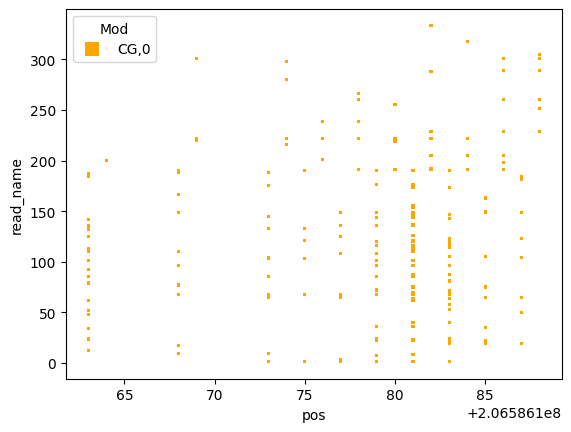

In [21]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = 'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    relative = False,
    window_size = None, # 5000,
    s=5,
)

<Axes: xlabel='pos', ylabel='read_name'>

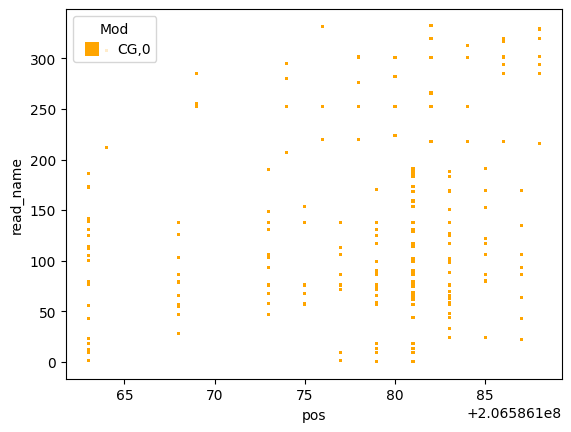

In [22]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = 'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    relative = False,
    window_size =  5000, # None, #
    s=5,
)

In [23]:
# chr1_
206586162-206586192


-30

In [24]:

# ref_genome_v1_1_file
window_size = 4000
outname = f'cd55_window{window_size}'
num_cores = 32

# cas9 = parse_bam.extract(
#     input_file=bam_cas9_12ef_101923_updated, # cd55_filepath,
#     output_name=outname,
#     ref_genome=ref_genome_v1_1_file, # '/clusterfs/nilah/oberon/genomes/chm13.draft_v1.1.fasta',
#     regions=t2t_cd55_30bps, # bed_files="chr1:206586162-206586192", # [bed_region],
#     basemods=['CG,0'],
#     cores=num_cores,
#     thresh=0.75,
#     window_size=window_size,
# )
t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'

# = extract_file, extract_regions
cas9  = parse_bam.extract(
    input_file=bam_path, # ctcf_bam_file_updated
    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh075', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_1_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=0.75, # 190,
    window_size=window_size, # None,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

     


No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.75 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_convert…

          |    0%

          | Transferring 366 from reads.CG,0.txt into reads.combined_basemods.h5, new size 366   0% | 00:00<?

In [25]:
extract_file_ws4000, extract_regions_ws4000 = cas9
extract_file_ws4000


PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh075/reads.combined_basemods.h5')

Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

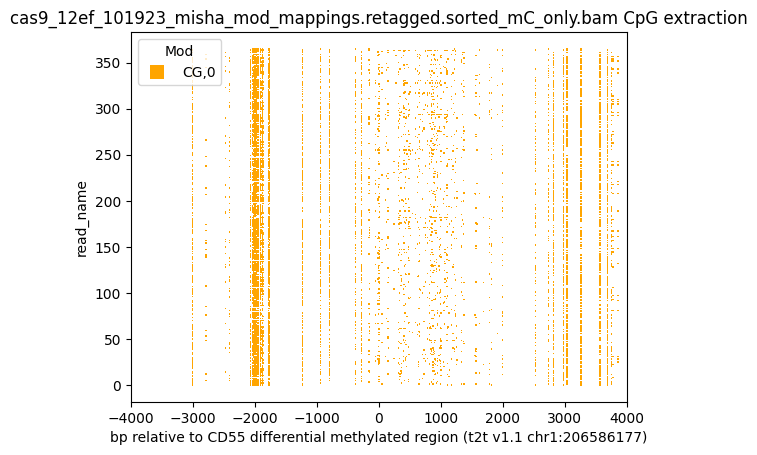

In [26]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')
     


Text(0.5, 0, 'bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')

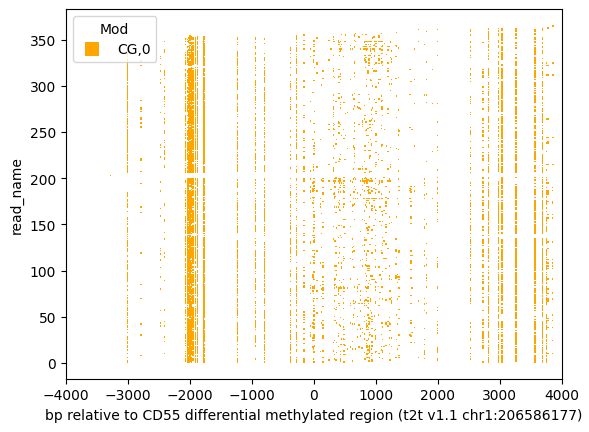

In [27]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['strand'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
# plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



# Sort reads by the region start

<Axes: xlabel='pos', ylabel='read_name'>

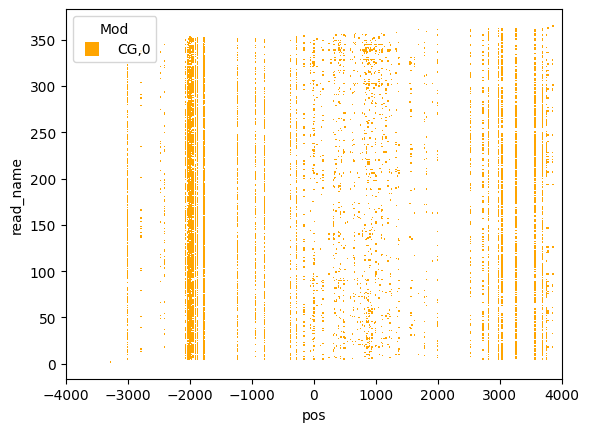

In [28]:
# Sort reads by the region start

plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
# plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
# plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')


Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

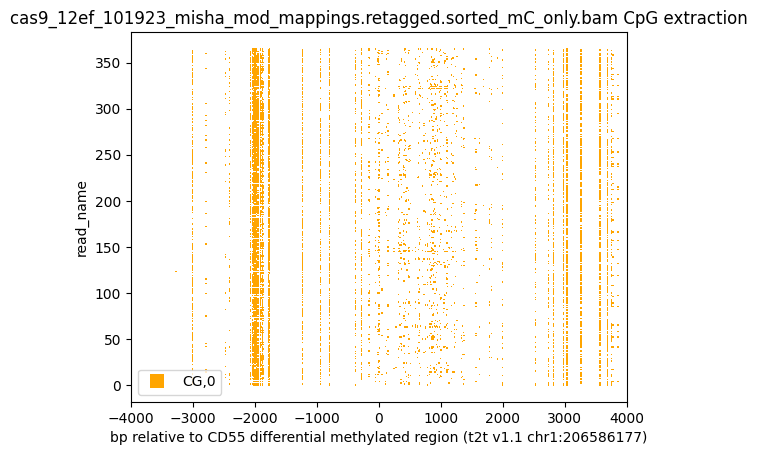

In [29]:
ax=plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start', 'shuffle'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
ax.get_legend() 
#only works after the legend was created. Try
leg = ax.legend()

plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

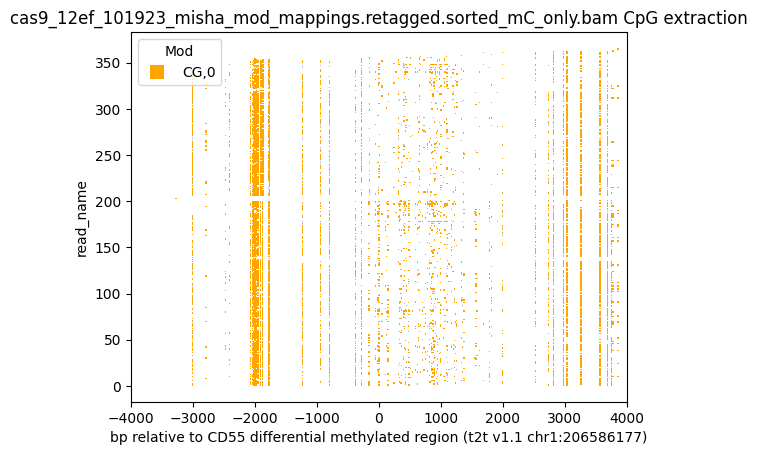

In [30]:
ax = plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start', 'strand'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')


Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

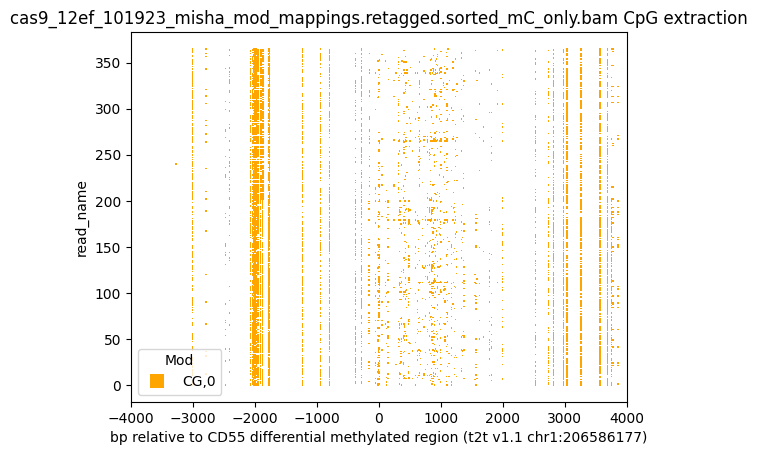

In [31]:
ax = plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['shuffle','strand'], # ['region_start', 'strand'], #
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')


CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e4e6850>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

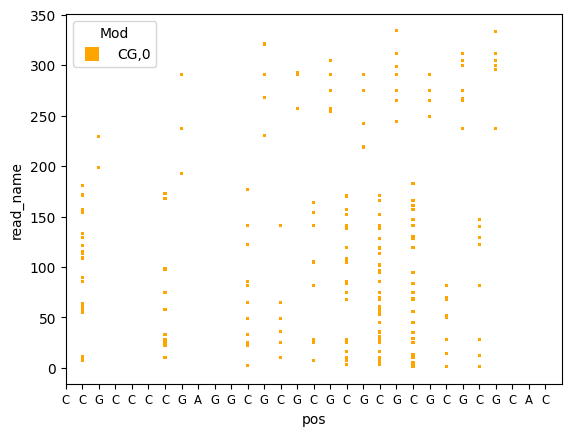

In [32]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e270590>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

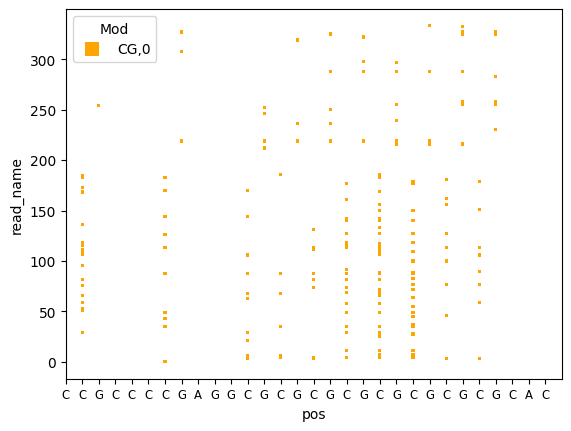

In [33]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e224d90>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

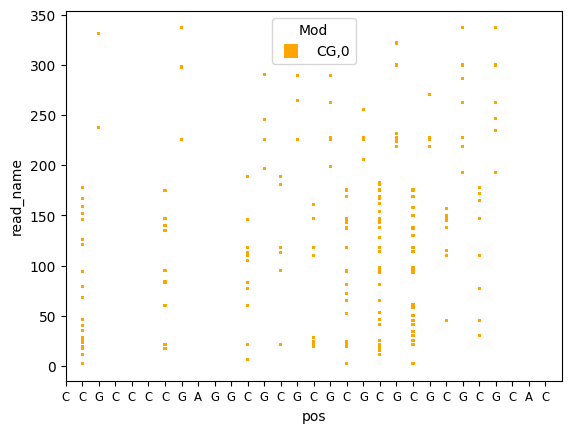

In [34]:

from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle', 'strand'], # 'region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e1d6c50>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

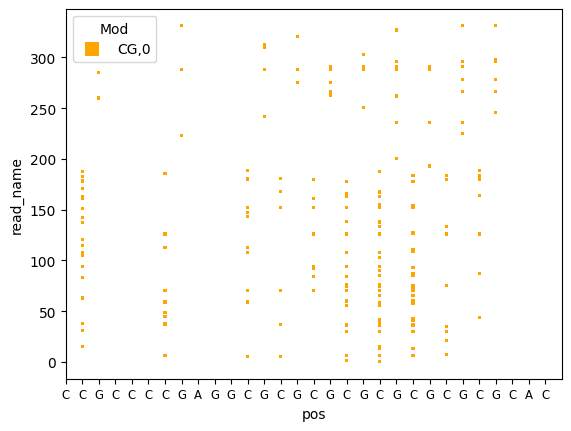

In [35]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle', 'strand', 'region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e3a4a50>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

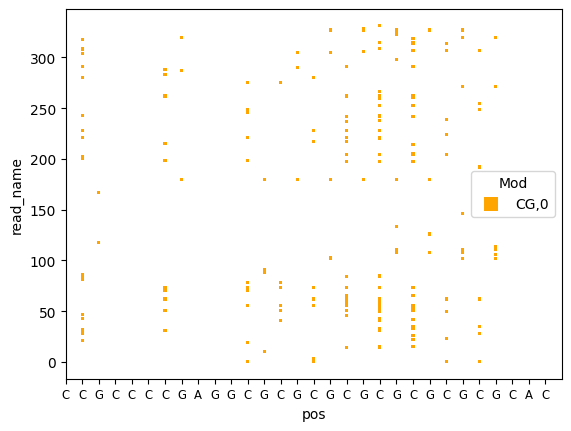

In [36]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')
     

In [37]:
seq_list

['C',
 'C',
 'G',
 'C',
 'C',
 'C',
 'C',
 'G',
 'A',
 'G',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'G',
 'C',
 'A',
 'C']

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615e56ebd0>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

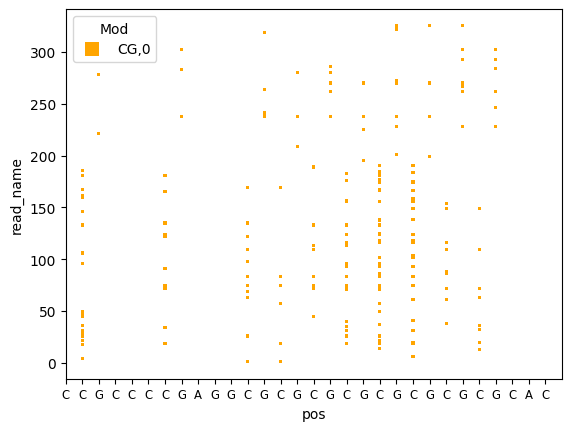

In [38]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')
     

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7c615df1a210>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

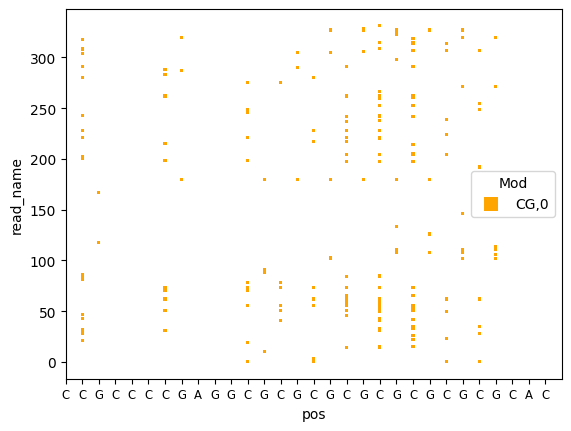

In [39]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_1_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['region_end','region_start' ], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

In [40]:
extract_file

PosixPath('dimelo_v2_output/cas9_12ef_101923_beta_extract_30bps_chr1_206586162_206586192_wsNone_thresh190/reads.combined_basemods.h5')

# Extract structured on target reads

In [41]:
import numpy as np
import pandas as pd

from pathlib import Path

import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

from dimelo import parse_bam, plot_enrichment_profile, plot_reads, load_processed

     

In [42]:
t2t_v1_1_cd55_30bps

'chr1:206586162-206586192'

In [43]:
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

# from . import load_processed
# from . import utils

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_1_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    sort_by = ['strand'], # 'shuffle',
    window_size=None,
    thresh = 0.001, # vs.  0.00196,
    relative = True, # False, #

)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
    # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')
     

In [44]:
df

,read_name,mod,pos
0,0,"CG,0",-4
1,0,"CG,0",0
2,0,"CG,0",8
3,0,"CG,0",10
4,3,"CG,0",0
...,...,...,...
187,330,"CG,0",3
188,330,"CG,0",5
189,330,"CG,0",7
190,330,"CG,0",9


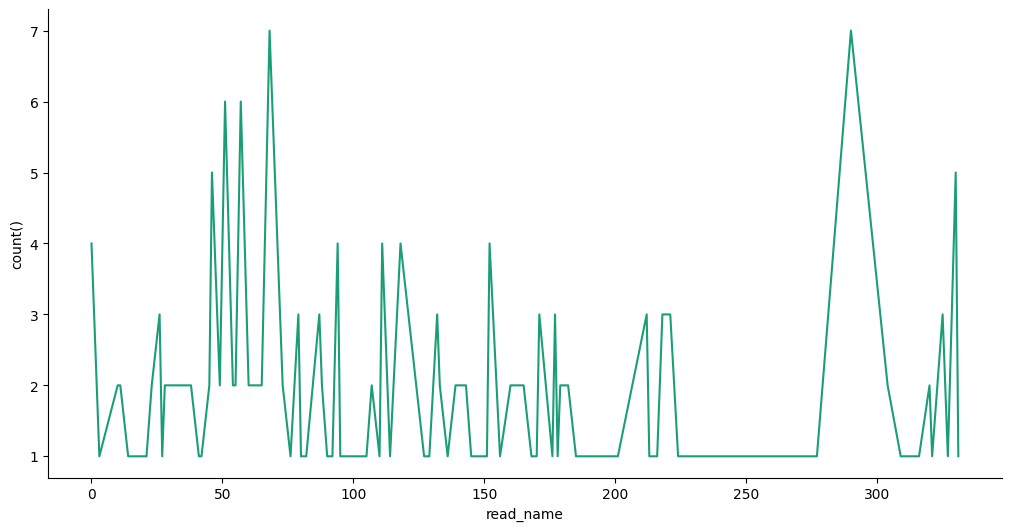

In [45]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

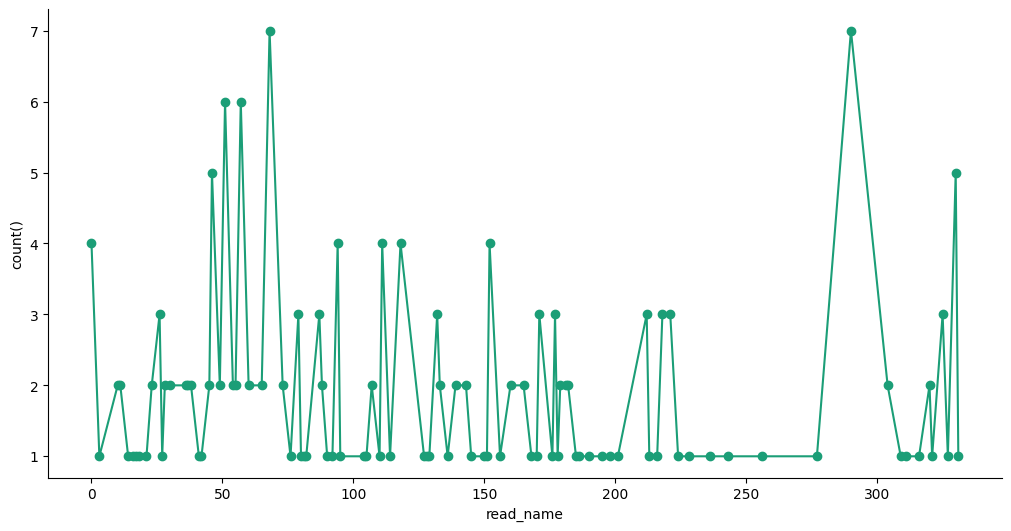

In [46]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], marker='o' )

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

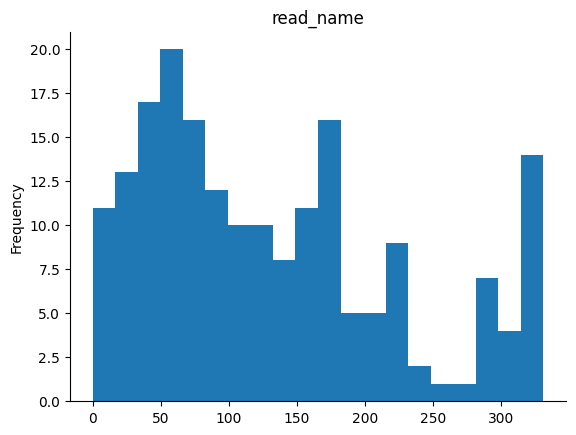

In [47]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)
     


In [48]:
len(np.unique(df['read_name']))


100

In [49]:

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_1_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    relative = False,
    thresh=0.001,
    # window_size = None, # window_size,
)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
  # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df_with_coords = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')
     

len(np.unique(df_with_coords.read_name))
     
30

df_with_coords

,read_name,mod,pos
0,0,"CG,0",206586178
1,0,"CG,0",206586180
2,0,"CG,0",206586182
3,0,"CG,0",206586184
4,0,"CG,0",206586186
...,...,...,...
187,324,"CG,0",206586180
188,327,"CG,0",206586163
189,328,"CG,0",206586181
190,329,"CG,0",206586176


In [50]:
df_with_coords.shape

(192, 3)

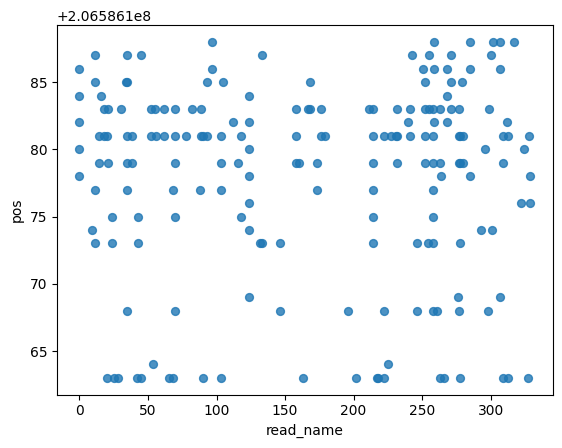

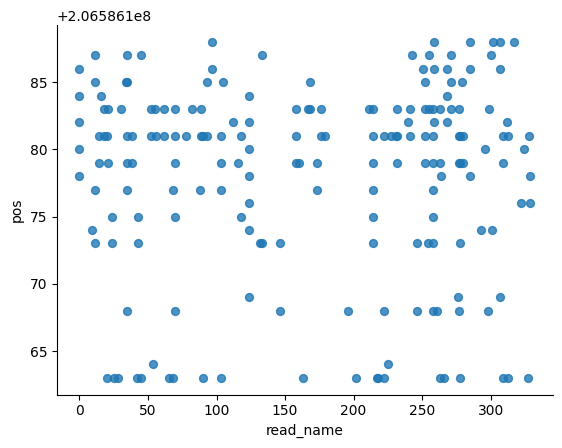

In [51]:
# @title read_name vs pos

from matplotlib import pyplot as plt
df_with_coords.plot(kind='scatter', x='read_name', y='pos', s=32, alpha=.8)
df_with_coords.plot(kind='scatter', x='read_name', y='pos', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
    

# Pile up reads

In [52]:
# pileup_file, pileup_regions = parse_bam.pileup(
#     input_file=ctcf_bam_file_updated,
#     output_name='ctcf_demo_pileup_on_target',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     regions=[ctcf_target_regions,ctcf_off_target_regions],
#     motifs=['A,0','CG,0'],
#     # parsing can optionally specify mod codes. 
#     # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
#     # motifs = ['A,0,Y','CG,0,Z'], 
#     thresh=190,
#     window_size=1000,
#     # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
#     # quiet = True,
#     # cleanup = False,
#     # log=True,
# )

In [53]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20241127_Cas9_K562unedited_day2_R9_minion/post_seq_basecall/5mCG/to_t2t_v1_1/sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_converted_fast5.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [54]:
output_dir

PosixPath('dimelo_v2_output')

In [55]:
pileup_file, pileup_regions = parse_bam.pileup(
    input_file=bam_path, # ctcf_bam_file_updated,
    output_name= "pileup_extract_K562_P2_30bps_chr1_206586162_206586192_wsNone_thresh190", # 'ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_v1_1_file, #ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_1_cd55_30bps, #[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    # motifs = ['A,0,Y','CG,0,Z'], 
    thresh=190,
    window_size=None,
    # window_size=4000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_convert…

          |    0%

In [56]:
pileup_file, pileup_regions = parse_bam.pileup(
    input_file=bam_path, # ctcf_bam_file_updated,
    output_name= "pileup_extract_K562_P2_ws4000_around_chr1_206586162_206586192_thresh190", # 'ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_v1_1_file, #ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_1_cd55_30bps, #[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    # parsing can optionally specify mod codes. 
    # The default is Y or a for adenine and m or Z for cytosine, corresponding to methylation
    # motifs = ['A,0,Y','CG,0,Z'], 
    thresh=190,
    # window_size=None,
    window_size=4000,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v1_1_trim_20241127_MR_Cas9_K562unedited_day2_R9min_convert…

          |    0%

In [57]:
# # using domelo modkit_parsing_main :
# t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
# # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'

# # using domelo modkit_parsing_main:
# pileup_file = parse_bam.pileup(
#     input_file=bam_path, #ctcf_bam_file,
#     output_name='pileup_extract_K562_P2_30bps_chr1_206586162_206586192_wsNone_thresh190', #'ctcf_demo_pileup',
#     ref_genome=ref_genome_v1_1_file, # ref_genome_file,
#     output_directory=output_dir,
#     region_str=t2t_v1_1_cd55_30bps, # bed_files= [ctcf_target_regions],
#     basemods=['CG,0'],
#     thresh=190,
#     window_size=None,
#     # window_size=1000,
#     # cores=None,
#     # cleanup=False
# )

<Axes: xlabel='pos', ylabel='fraction modified bases'>

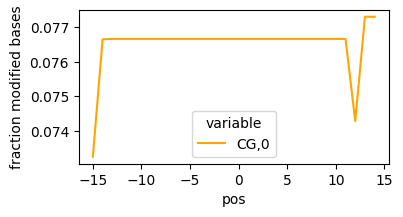

In [58]:
plt.figure(figsize=(4, 2)) # If you want a different sized plot, you can us matplotlib commands
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    regions=t2t_v1_1_cd55_30bps, #ctcf_target_regions,
    window_size=None, #1000,
    motifs=['CG,0'], # ['A,0','CG,0'],
    single_strand=False, # if set to True, regions that specify the strand will only pull from reads on the strand (as opposed to both strands)
    regions_5to3prime=False, # if set to True, regions on the reverse (-) strand will be flipped so everything is 5 prime to 3 prime
    smooth_window=50,
    palette = { # you can pass down kwargs to sns barplot if you want to
        # 'A,0':'blue',
        'CG,0':'orange'
    }
)

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


/tmp/ipykernel_2056175/2540628470.py:9: RuntimeWarning: invalid value encountered in divide
  pileup_frac = mod_counts_vector / val_counts_vector


([<matplotlib.axis.XTick at 0x7c615db46ad0>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

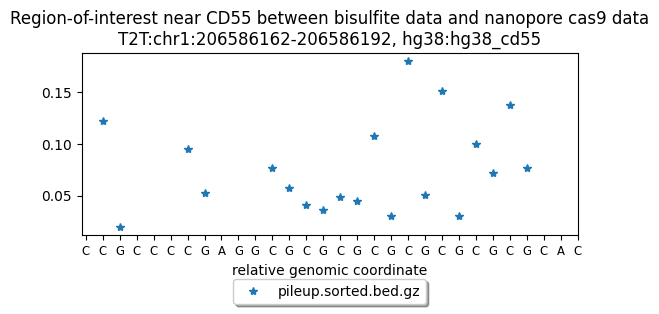

In [59]:
fig, ax = plt.subplots()

mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = pileup_file, # file,
        motif = 'CG,0',
        regions = t2t_v1_1_cd55_30bps, # region,
        window_size = None
    )
pileup_frac = mod_counts_vector / val_counts_vector
ax.plot(pileup_frac,'*',label=Path(pileup_file).name)

plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_v1_1_cd55_30bps}, hg38:{"hg38_cd55"}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

In [60]:
pileup_frac

array([       nan, 0.12195122, 0.01980198,        nan,        nan,
              nan, 0.0952381 , 0.05263158,        nan,        nan,
              nan, 0.07692308, 0.05714286, 0.04137931, 0.03658537,
       0.04848485, 0.04464286, 0.10795455, 0.03100775, 0.17977528,
       0.05109489, 0.1509434 , 0.03076923, 0.1       , 0.07216495,
       0.13793103, 0.07692308,        nan,        nan,        nan])

NameError: name 'caspileup' is not defined

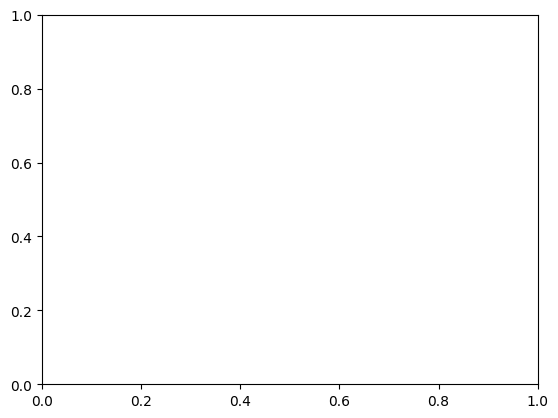

In [61]:
# from matplotlib import pyplot as plt
# t2t_cd55 = 'chr1:206586162-206586192'
# # hg38_cd55 = 'chr1:207320867-207320897'

# # caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
# # caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
# # T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
# K562_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

from dimelo import plot_enrichment_profile
from dimelo import load_processed
import pysam

fig, ax = plt.subplots()

for file,region in zip([caspileup,T_bedgz],
                       [t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    pileup_frac = mod_counts_vector / val_counts_vector
    ax.plot(pileup_frac,'*',label=Path(file).name)

plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

In [60]:
# from matplotlib import pyplot as plt
# t2t_cd55 = 'chr1:206586162-206586192'
# # hg38_cd55 = 'chr1:207320867-207320897'

# # caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
# # caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
# # T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
# K562_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

# from dimelo import plot_enrichment_profile
# from dimelo import load_processed
# import pysam

# fig, ax = plt.subplots()

# for file,region in zip([caspileup,T_bedgz],[t2t_cd55,hg38_cd55]):
#     mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
#         bedmethyl_file = file,
#         motif = 'CG,0',
#         regions = region,
#         window_size = None
#     )
#     pileup_frac = mod_counts_vector / val_counts_vector
#     ax.plot(pileup_frac,'*',label=Path(file).name)

# plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
# plt.xlabel('relative genomic coordinate')
# # plt.legend()
# plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# # Placing the legend at the bottom outside of the figure
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')